In [1]:

import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
#Read the data into a pandas data frame 
df = pd.read_parquet("de_train.parquet")
df_copy = df

In [3]:
#normalizes data between -1 and 1
#returns normalized data and the factors used to normalzie 
def normalize(df):
    min = df.min()
    max=df.max()
    df_normalized = (df - min) / (max-min)
    return df_normalized, min.reset_index(drop=True), max.reset_index(drop=True)


#unnormalize
def unnormalize(normalized_df, min, max):
    return min + normalized_df*(max-min)

In [4]:
############################DATA PREP###############################



####One hot incodes inputs####

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
cells = df["cell_type"].values.reshape(-1, 1)
hot_cells = encoder.fit_transform(cells)
cell_mapping = encoder.categories_[0]

compounds = df['sm_name'].values.reshape(-1, 1)
hot_compounds = encoder.fit_transform(compounds)
compound_mapping = encoder.categories_[0]

#Puts together inputs
inputs = np.hstack((hot_cells, hot_compounds))
inputs_df = pd.DataFrame(data = inputs)


####Normalizes Outputs####

outputs = df.loc[:, 'A1BG':'ZZEF1']
outputs_norm_df, norm_min, norm_max = normalize(outputs)


####Puts Inputs and Outputs Together####
prepped_df = pd.concat([inputs_df, outputs_norm_df], axis=1)



In [5]:
#Break into training and validation and split inputs from outputs
val, train = train_test_split(prepped_df, train_size=.2, random_state=3)
trainIn_df = train.loc[:, 0:151]
trainOut_df = train.loc[:, 'A1BG':'ZZEF1']
valIn_df = val.loc[:,0:151]
valOut_df = val.loc[:, 'A1BG':'ZZEF1']

#Transforms data frames into tensors
trainIn_t = torch.tensor(trainIn_df.values)
trainOut_t = torch.tensor(trainOut_df.values)
valIn_t = torch.tensor(valIn_df.values)
valOut_t = torch.tensor(valOut_df.values)




In [6]:
#layers is the number of hidden layers (function only defined for one or two layers)
#sizes is a list with the sizes of each layer [input, hidden1, optional hidden 2, output]
def build_model(layers):
    if len(layers) == 3:
        #Build each layer of nueral network
        #Provide forward method to train network
        class Layer1(nn.Module):
            def __init__(self, input_size, hidden1_size, num_classes):
                #Initialzing layers
                super(Layer1, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden1_size)
                self.relu1 = nn.ReLU()
                self.fc2 = nn.Linear(hidden1_size, num_classes)
                self.act_output = nn.Sigmoid()
            #training function
            def forward(self,x):
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)
                out = self.act_output(out)
                return out
            
        #Instantiate class with input, hidden layer, and output size 
        model1 = Layer1(layers[0],layers[1],layers[2])
        #Change to double data type
        model1.double()
        return model1
    elif len(layers) == 4:
        #Build each layer of nueral network
        #Provide forward method to train network
        class Layer2(nn.Module):
            def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
                #Initialzing layers
                super(Layer2, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden1_size)
                self.relu1 = nn.ReLU()
                self.fc2 = nn.Linear(hidden1_size, hidden2_size)
                self.relu2 = nn.ReLU()
                self.fc3 = nn.Linear(hidden2_size, num_classes)
                self.act_output = nn.Sigmoid()
            #training function
            def forward(self,x):
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)
                out = self.relu2(out)
                out = self.fc3(out)
                out = self.act_output(out)
                return out
            
        #Instantiate class with input, hidden layer, and output size 
        model2 = Layer2(layers[0],layers[1],layers[2],layers[3])
        #Change to double data type
        model2.double()
        return model2
    else:
        print("Invalid number of hidden layers")

In [7]:

#training loop 

def train(epoch_number, batch_size, layers):
    model = build_model(layers)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    epoch_test_losses = []
    epoch_val_losses = []
    
    for epoch in range(epoch_number):
        batch_losses = []
        for i in range(0, len(trainIn_t), batch_size):
            Xbatch = trainIn_t[i:i+batch_size]
            ybatch = trainOut_t[i:i+batch_size]
            
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After each epoch, get the mean loss for the train and validation data.
        epoch_test_loss = np.mean(batch_losses)
        epoch_test_losses.append(epoch_test_loss)

        with torch.no_grad():
            y_pred = model(valIn_t)
            epoch_val_loss = loss_fn(y_pred,valOut_t)
        epoch_val_losses.append(epoch_val_loss)
        
                
        print(f"Epoch {epoch}, Training Loss: {epoch_test_loss}, Validation Loss: {epoch_val_loss}")
    
    return epoch_test_losses, epoch_val_losses, model



Epoch 0, Training Loss: 0.555547768493433, Validation Loss: 0.5310574810875732
Epoch 1, Training Loss: 0.525386394972972, Validation Loss: 0.5286252946025446
Epoch 2, Training Loss: 0.5231316555266201, Validation Loss: 0.5271107953154209
Epoch 3, Training Loss: 0.5217865734984296, Validation Loss: 0.5265405387434182
Epoch 4, Training Loss: 0.5209376467243582, Validation Loss: 0.5263422197231948
Epoch 5, Training Loss: 0.5202593267509557, Validation Loss: 0.5262219798852853
Epoch 6, Training Loss: 0.5196378060677651, Validation Loss: 0.5261239576709222
Epoch 7, Training Loss: 0.5190354475010297, Validation Loss: 0.5260578032946879
Epoch 8, Training Loss: 0.5184376965519867, Validation Loss: 0.5260684091096152
Epoch 9, Training Loss: 0.517864569192712, Validation Loss: 0.5261467841803432
Epoch 10, Training Loss: 0.5173373703538393, Validation Loss: 0.5262996179045845
Epoch 11, Training Loss: 0.5168716328803273, Validation Loss: 0.5265269154530986
Epoch 12, Training Loss: 0.51647506167374

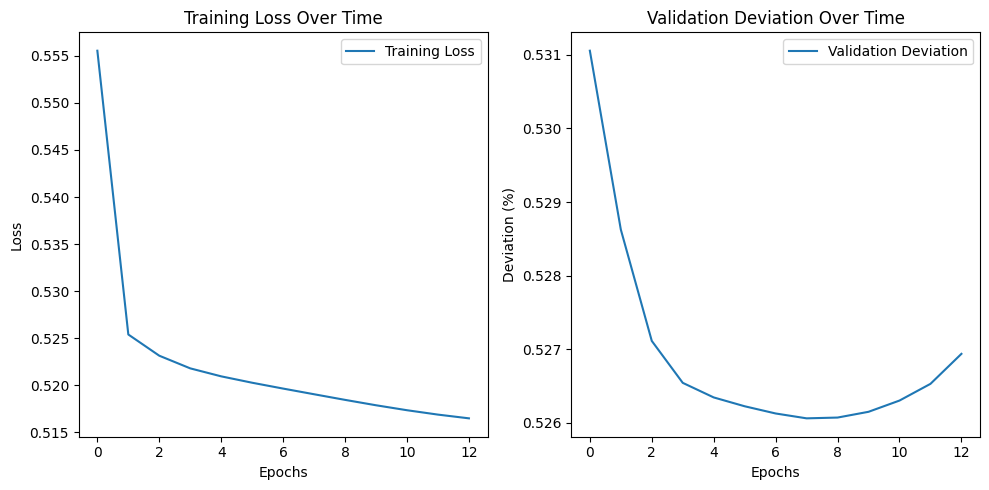

In [8]:

# Call your train(epochs, batch size, layers) function
train_losses, test_losses, model = train(13, 20, [152,4000,18211])

# Now plot the loss over epochs
plt.figure(figsize=(10, 5))

# Plotting the training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()


# Plotting the deviation over epochs
plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Validation Deviation')
plt.xlabel('Epochs')
plt.ylabel('Deviation (%)')
plt.title('Validation Deviation Over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
def hot_encode(cell,compound):
    cell_vec = np.zeros(cell_mapping.size)
    cell_dict = {value: index for index, value in enumerate(cell_mapping)}

    compound_vec = np.zeros(compound_mapping.size)
    compound_dict = {value: index for index, value in enumerate(compound_mapping)}


    cell_vec[cell_dict[cell]]=1
    compound_vec[compound_dict[compound]]=1
    vector = np.concatenate((cell_vec, compound_vec), axis = 0)
    tensor = torch.from_numpy(vector)
    return tensor


In [10]:
model(hot_encode("NK cells", "Clotrimazole"))

tensor([0.1427, 0.2528, 0.4791,  ..., 0.4230, 0.4569, 0.5523],
       dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [11]:
def get_expression(cell_type, compound_name):
    tensor = model(hot_encode(cell_type,compound_name))
    np_array = tensor.detach().numpy()
    df = pd.DataFrame(np_array)
    return unnormalize(df[0],norm_min,norm_max)


df = get_expression("NK cells", "Clotrimazole")
print(df)




0        0.357187
1        0.607244
2       -1.670510
3       -1.101161
4        0.135851
           ...   
18206    0.280343
18207   -0.200327
18208    0.045046
18209   -0.328001
18210   -0.205399
Length: 18211, dtype: float64


In [12]:
# Read the sample submission and test set ID map
sample_submission = pd.read_csv("sample_submission.csv")
testDf = pd.read_csv("id_map.csv")

# Initialize an empty list to collect the predicted values
predicted_values = []

# Loop through the test set to get the predicted values
for idx, row in testDf.iterrows():
    cell_type = row['cell_type']
    sm_name = row['sm_name']
    
    # Call your get_expression method here
    expression_values = get_expression(cell_type, sm_name)
    
    # Append the values to the list
    predicted_values.append(expression_values)

# Convert the list of predicted values to a numpy array
predicted_values_array = np.array(predicted_values)

# Replace the values in the sample submission DataFrame
sample_submission.iloc[:, 1:] = predicted_values_array

# Save the DataFrame to a new CSV file
sample_submission.to_csv("my_submission.csv", index=False)



FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

In [ ]:
row_one = copy_df.iloc[0][5:]
row_one_output = get_expression(copy_df.iloc[0][0], copy_df.iloc[0][1])

for i in range( len(row_one)):
    print(f"{row_one[i]}     {row_one_output[i]}")